In [ ]:
!pip install opendatasets

In [ ]:
# Import necessary libraries
import os
import opendatasets as od
import tensorflow as tf
from tensorflow.keras import models,applications,layers,losses,callbacks
from sklearn.metrics import confusion_matrix,classification_report
import numpy as np
import seaborn as sn
import pathlib
import PIL
import cv2
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import cv2
import numpy as np
from pathlib import Path
from google.colab.patches import cv2_imshow
from tensorflow.keras import applications


In [ ]:
#Defining the dataset URL
dataset_url = "https://www.kaggle.com/datasets/alxmamaev/flowers-recognition?datasetId=8782&sortBy=voteCount"

#Defining the data directory
data_dir = './flowers-recognition/flowers'

#If there is no folder, download the dataset
if not os.path.isdir(data_dir):
    od.download(dataset_url)

#List classes
classes = os.listdir(data_dir)
print(classes)



Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: ilaybozkurt
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/alxmamaev/flowers-recognition
['dandelion', 'tulip', 'sunflower', 'daisy', 'rose']


Numpy array shape: (159, 240, 3)
Data type: uint8
Min/Max values: 0 255


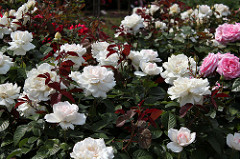

In [ ]:
#Define the data directory (custom structure for Kaggle)
data_dir = Path("./flowers-recognition/flowers")

#Collecting images of each flower type in the dictionary
flowers_img_dict = {
    'rose': list((data_dir/'rose').glob('*.jpg')),
    'daisy': list((data_dir/'daisy').glob('*.jpg')),
    'dandelion': list((data_dir/'dandelion').glob('*.jpg')),
    'sunflower': list((data_dir/'sunflower').glob('*.jpg')),
    'tulip': list((data_dir/'tulip').glob('*.jpg')),
}

#Assigning numerical labels to each flower type
flowers_lbl_dict = {
    'daisy': 0,
    'dandelion': 1,
    'rose': 2,
    'sunflower': 3,
    'tulip': 4
}


#Read and show the first rose image
if len(flowers_img_dict['rose']) > 0:
    img = cv2.imread(str(flowers_img_dict['rose'][0]))

    #Print image information
    print('Numpy array shape:', img.shape)
    print('Data type:', img.dtype)
    print('Min/Max values:', np.min(img), np.max(img))

    #Show image
    cv2_imshow(img)

else:
    print("No rose images found!")
    print("Current directory structure:", [p.name for p in data_dir.iterdir() if p.is_dir()])

In [ ]:
# Reading an image as numpy array
img=cv2.imread(str(flowers_img_dict['rose'][0]))
print('numpy array of an image:\n',img)


numpy array of an image:
 [[[  4  10  33]
  [  1  16  35]
  [ 56  79  94]
  ...
  [ 41  68  52]
  [ 45  68  54]
  [ 47  64  55]]

 [[  4  11  44]
  [  5  19  48]
  [  0  20  42]
  ...
  [ 32  61  46]
  [ 34  58  48]
  [  6  24  17]]

 [[ 21  35  54]
  [  0  13  32]
  [  0   0  14]
  ...
  [ 46  76  65]
  [ 46  70  62]
  [  8  27  24]]

 ...

 [[ 60  84  72]
  [ 98 123 113]
  [114 139 129]
  ...
  [ 12  23  15]
  [ 18  25  20]
  [  9  13   8]]

 [[ 51  74  60]
  [112 138 125]
  [115 140 130]
  ...
  [ 12  23  15]
  [ 17  24  19]
  [  5   9   4]]

 [[ 30  50  37]
  [ 95 119 107]
  [ 46  70  60]
  ...
  [ 15  26  18]
  [ 17  24  19]
  [  1   5   0]]]


In [ ]:
# check number of images in each type of flowers
for fldr_name,images in flowers_img_dict.items():
  print(fldr_name)
  print(len(images))

rose
784
daisy
764
dandelion
1052
sunflower
733
tulip
984


In [ ]:
#Creates the input (X) and label (Y) dataset from flower images and resizes each image to the same size (100x100 pixels)
#The model is brought to the required format for training.
X,Y=[],[]
for flowr_name,images in flowers_img_dict.items():
  for image in images:
    img=cv2.imread(str(image))
    resized_img=cv2.resize(img,(224,224))
    X.append(resized_img)
    Y.append(flowers_lbl_dict[flowr_name])

In [ ]:
#Converting lists to NumPy arrays
X=np.array(X)
Y=np.array(Y)
print('X:\n',X)
print('Y\n',Y)

X:
 [[[[  4  10  33]
   [  7  23  41]
   [ 55  77  91]
   ...
   [ 40  67  51]
   [ 44  68  54]
   [ 47  64  55]]

  [[  4  11  39]
   [  5  21  45]
   [ 26  47  65]
   ...
   [ 34  62  47]
   [ 38  62  50]
   [ 24  42  34]]

  [[  8  17  47]
   [  3  17  43]
   [  3  19  37]
   ...
   [ 33  62  49]
   [ 37  62  52]
   [  8  26  20]]

  ...

  [[ 55  79  65]
   [109 134 122]
   [102 125 116]
   ...
   [ 13  24  16]
   [ 17  24  19]
   [  6  10   6]]

  [[ 44  66  52]
   [102 127 115]
   [ 74  97  87]
   ...
   [ 14  25  17]
   [ 17  24  18]
   [  4   8   3]]

  [[ 32  52  39]
   [ 90 114 102]
   [ 40  62  53]
   ...
   [ 15  26  18]
   [ 17  24  19]
   [  1   6   1]]]


 [[[  0  20   5]
   [  1  20   6]
   [  1  17   6]
   ...
   [  0  11  21]
   [  3  13  23]
   [  2  12  22]]

  [[  3  27  11]
   [  2  25  10]
   [  3  22   9]
   ...
   [  1  10  20]
   [  2  11  22]
   [  1   8  21]]

  [[  4  30  12]
   [  3  27  10]
   [  3  25  10]
   ...
   [  0   8  17]
   [  0   7  20]
   [  0

In [ ]:
#divides the image and label data you create into training (train) and test (test) sets.
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,random_state=0)
print('size of X_train:',X_train.shape)
print('size of X_test:',X_test.shape)
print('size of Y_train:',Y_train.shape)
print('size of Y_test:',Y_test.shape)

size of X_train: (3237, 224, 224, 3)
size of X_test: (1080, 224, 224, 3)
size of Y_train: (3237,)
size of Y_test: (1080,)


In [ ]:
# Normalize the pixel values to the range [0, 1]
X_train=X_train/255
X_test=X_test/255

In [ ]:
#Allows defining the input type to be used in the model
input_shape = (224, 224)
IMG_SIZE = input_shape + (3,)


In [ ]:
# Function to create and compile the model
def my_model():
  #It takes VGG16 pre-trained with ImageNet.Top layers are excluded.
  network=applications.VGG16(input_shape=IMG_SIZE,
                             include_top=False,
                             weights='imagenet')


  #VGG16 weights are not updated during training.Several fully-connected layers are added on top of it.
  network.trainable=False
  model=models.Sequential([
      network,
      layers.Flatten(),
      layers.Dense(128,activation='relu'),
      layers.Dense(64,activation='relu'),
      layers.Dense(32,activation='relu'),
      layers.Dense(5,activation='softmax')
  ])


  #The model is compiled with Adam optimization and accuracy metric.
  model.compile(
      optimizer='adam',
      loss=losses.sparse_categorical_crossentropy,
      metrics=['accuracy']
  )
  return model




In [ ]:
# Function to evaluate the model
def eval(model, X, Y):
    model.evaluate(X, Y)


# Function for making predictions
def prediction(model, X, Y):
    Y_predict = model.predict(X)
    Y_pred = [np.argmax(i) for i in Y_predict]
    print('Predicted the first five labels:', Y_pred[:5])
    print('True labels of the first five elements:', Y[:5])
    return Y_pred

# Function to display classification report and confusion matrix
def report(truth, predictions):
    print(classification_report(truth, predictions))
    cm = confusion_matrix(truth, predictions, normalize='true')  # Normalize edilmiş değerler
    plt.figure(figsize=(10, 7))
    sn.heatmap(cm, annot=True, fmt='.2f', cmap='Blues')
    plt.title('Normalized Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')


# Function to plot training and validation loss
def plot_loss(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

# Function to plot training and validation accuracy
def plot_accuracy(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.show()


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Creating a DataGenerator for training data.The goal: to reduce overfitting.
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

#Creating a DataGenerator for validation data
val_datagen = ImageDataGenerator(rescale=1./255)

#Loading training data from folder
train_generator = train_datagen.flow_from_directory(
    'flowers-recognition/flowers',
    target_size=(224, 224),
    batch_size=16,
    class_mode='sparse',
    shuffle=True
)

#Loading validation data from Folder
val_generator = val_datagen.flow_from_directory(
    'flowers-recognition/flowers',
    target_size=(224, 224),
    batch_size=16,
    class_mode='sparse',
    shuffle=False
)

#Define and Train the Model
model = my_model()

#Fitting (Training) the Model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20
)


Found 4317 images belonging to 5 classes.
Found 4317 images belonging to 5 classes.
Epoch 1/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 91s 327ms/step - accuracy: 0.5961 - loss: 1.1046 - val_accuracy: 0.8135 - val_loss: 0.5306
Epoch 2/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 139s 320ms/step - accuracy: 0.7673 - loss: 0.6361 - val_accuracy: 0.8457 - val_loss: 0.4351
Epoch 3/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 88s 325ms/step - accuracy: 0.8276 - loss: 0.5086 - val_accuracy: 0.8429 - val_loss: 0.4206
Epoch 4/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 91s 337ms/step - accuracy: 0.8450 - loss: 0.4421 - val_accuracy: 0.8900 - val_loss: 0.3203
Epoch 5/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 87s 324ms/step - accuracy: 0.8522 - loss: 0.4050 - val_accuracy: 0.8645 - val_loss: 0.3615
Epoch 6/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 87s 324ms/step - accuracy: 0.8519 - loss: 0.3904 - val_accuracy: 0.9083 - val_loss: 0.2474
Epoch 7/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 89s 331ms/step - accuracy: 0.8818 - loss: 0.3325 - val_accuracy: 0.9263 - val_loss: 0.212

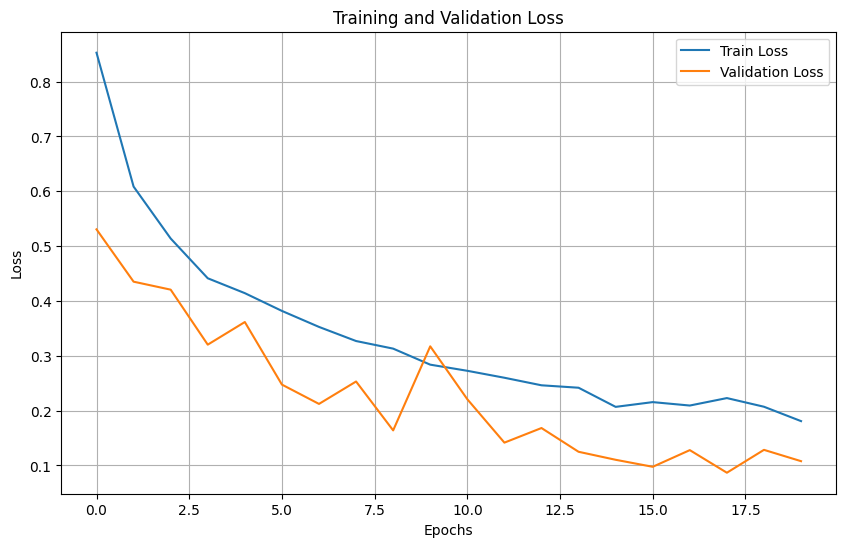

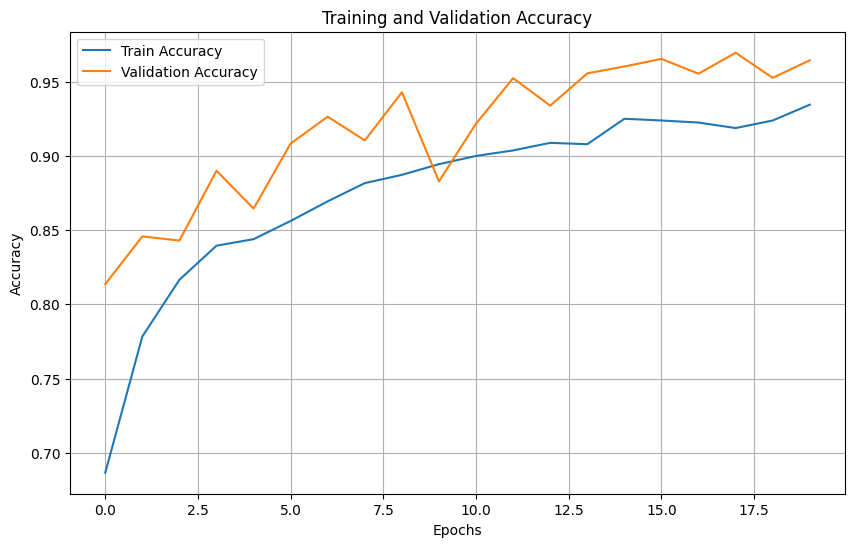

34/34 ━━━━━━━━━━━━━━━━━━━━ 30s 489ms/step - accuracy: 0.8810 - loss: 0.4276
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 192ms/step
Predicted the first five labels: [np.int64(3), np.int64(0), np.int64(1), np.int64(2), np.int64(4)]
True labels of the first five elements: [3 0 1 2 4]
              precision    recall  f1-score   support

           0       0.75      0.92      0.83       184
           1       0.89      0.94      0.92       243
           2       0.96      0.74      0.84       214
           3       0.83      0.84      0.83       177
           4       0.93      0.90      0.91       262

    accuracy                           0.87      1080
   macro avg       0.87      0.87      0.87      1080
weighted avg       0.88      0.87      0.87      1080



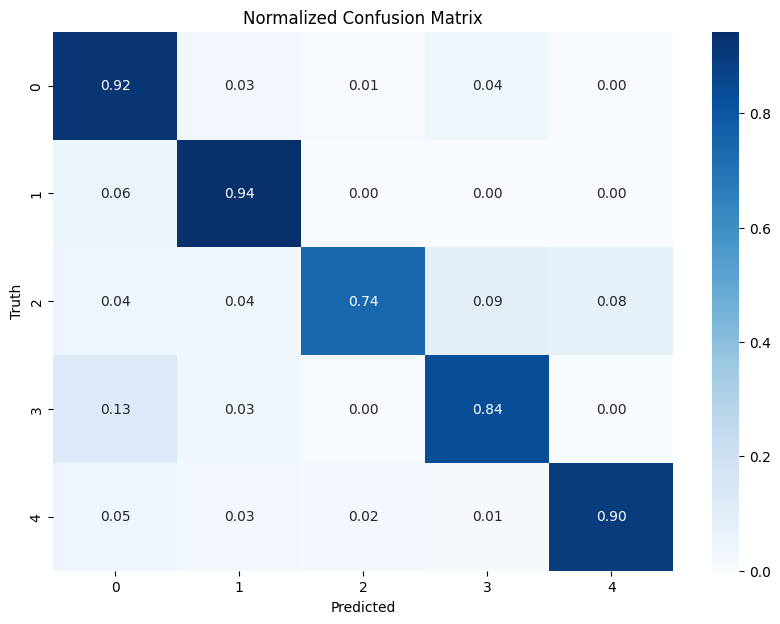

In [ ]:
# Graphics
plot_loss(history)
plot_accuracy(history)


# Evaluation
eval(model, X_test, Y_test)

# Report
Y_pred = prediction(model, X_test, Y_test)
report(Y_test, Y_pred)